This notebook has all the componenets of the ENKEFALOS application. Run the cells in the order they are in to prevent errors and get all results. To run the code, highlight the cell you want and click "Run", or press Shift+Enter

# Setup

Run the cell below. An input box will pop up asking you to paste in your list of differentially expressed (DE) genes. Paste them in seperated by spaces, or copy a column of genes from a spreadsheet. Once you paste them in, you will not be able to alter your list unless you rerun the cell.   

In [ ]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [1]:
import pandas as pd
from tkinter import *
from tkinter import scrolledtext
import matplotlib.pyplot as plt
import imageio as iio
import matplotlib
import numpy as np
import math
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import requests
from time import sleep
import json
import webbrowser
import networkx as nx
from matplotlib.pyplot import figure
import itertools
from watermark import watermark

matplotlib.style.use('default')
color_exc = '#006DDB'
color_inh = '#920000'

#File Paths for Bomkamp Data
path_1 = "online_table1.csv"
path_2 = "online_table2.csv"
path_3 = "online_table3.csv"
path_4 = "online_table4.csv"


scores = pd.read_csv(path_1, index_col = 0)
scores_all = pd.read_csv(path_2, index_col = 0)
ephys = pd.read_csv(path_3, index_col = 0, low_memory = False)
morph = pd.read_csv(path_4, index_col = 0, low_memory = False)

ephys.index = [str(n) for n in ephys.index]
morph.index = [str(n) for n in morph.index]

tmp = scores_all.drop_duplicates('gene_entrez_id')
tmp.index = tmp.gene_entrez_id.astype(str)
id_to_symbol = tmp.gene_symbol.to_dict()
symbol_to_id = {a:b for b,a in id_to_symbol.items()}

property_labels = {'apamp': 'AP Amplitude', 'ahpamp': 'AHP Amplitude', 'aphw': 'AP Half-width', 
                   'maxfreq': 'Max Firing Frequency', 'tau' : 'Time Constant Tau', 'rmp': 'Resting Membrane Potential',
                   'avg_isi': 'Average Interspike Interval', 'f_i_curve_slope': 'Input-Output Curve Slope',
                   'cap' : 'Capacitance', 'sag': 'Sag', 'ri': 'Input Resistance', 'rheo': 'Rheobase',
                   'adratio': 'Adaptation Ratio', 'apthr': 'AP Threshold', 
                   'latency' : 'Latency', 'isi_cv' : 'ISI CoV', 
                   'average_bifurcation_angle_local' : 'Bifurcation Angle', 'max_branch_order' : 'Max Branch Order', 
                   'branchiness' : 'Branchiness', 'total_length' : 'Total Length',
                   'total_volume' : 'Total Volume', 'soma_surface' : 'Soma Surface', 
                   'E_PC1': 'Electrophysiology PC1','E_PC2': 'Electrophysiology PC2', 
                   'E_PC3': 'Electrophysiology PC3', 
                   'M_PC1': 'Morphology PC1', 'M_PC2': 'Morphology PC2', 
                   'M_PC3': 'Morphology PC3'}

property_labels_units = {'apamp': 'AP Amplitude (mV)', 'ahpamp': 'AHP Amplitude (mV)', 'aphw': 'AP Half-width (ms)', 
                         'maxfreq': 'Max Firing\nFrequency (Hz)',
                         'tau' : 'Time Constant Tau (ms)', 'rmp': 'Resting Membrane Potential (mV)',
                         'avg_isi': 'Average Interspike Interval (ms)', 'f_i_curve_slope': 'Input-Output Curve\nSlope (Hz/pA)',
                         'cap' : 'Capacitance (pF)', 'sag': 'Sag', 'ri': u'Input Resistance (MΩ)', 'rheo': 'Rheobase (pA)',
                         'adratio': 'Adaptation Ratio', 'apthr': 'AP Threshold (mV)', 
                         'latency' : 'Latency (s)', 'isi_cv' : 'ISI CoV', 
                         'average_bifurcation_angle_local' : 'Bifurcation Angle (degrees)', 'max_branch_order' : 'Max Branch Order', 
                         'branchiness' : u'Branchiness\n(branches/μm)', 'total_length' : u'Total Length (μm)',
                         'total_volume' : u'Total Volume (μm^3)', 'soma_surface' : u'Soma Surface (μm^2)', 
                         'E_PC1': 'Electrophysiology PC1','E_PC2': 'Electrophysiology PC2', 
                         'E_PC3': 'Electrophysiology PC3', 
                         'M_PC1': 'Morphology PC1', 'M_PC2': 'Morphology PC2', 
                         'M_PC3': 'Morphology PC3'}

props_morph = ['average_bifurcation_angle_local', 'branchiness', 'max_branch_order', 'total_length',
               'total_volume', 'soma_surface', 'M_PC1', 'M_PC2', 'M_PC3']
props_all = property_labels.keys()
props_ephys = sorted(list(set(props_all).difference(set(props_morph))))
property_table = pd.DataFrame(list(property_labels.keys()), list(property_labels.values()), columns = ['Abbreviation'])


def make_scatter(gene, prop, ax = None, alpha = 0.6, s = 20, log = False, annotate_qvals = True):

    # Set up axes
    if ax == None:
        fig, ax = plt.subplots()    
    if log:
        ax.set_yscale('log')

    # Select data
    if type(gene) == str:
        gene = str(symbol_to_id[gene])
    elif type(gene) == int:
        gene = str(gene)
    df = morph if prop in props_morph else ephys
    line_labels = [{'exc': 1, 'inh': 0}[line.split('__')[-1]] for line in df.columns]
    x = df.loc[gene]        
    y = df.loc[prop]
    line_labels_gene = line_labels
    exc = [n > 0.5 for n in line_labels]
    inh = [n <= 0.5 for n in line_labels]

    # Remove zero values if there are too many
    not_zero = [val > 0 for val in x]
    x = x[not_zero]
    y = y[not_zero]
    exc = [a and b for a, b in zip(exc, not_zero)]
    inh = [a and b for a, b in zip(inh, not_zero)]
    line_labels_gene = [i for (i, v) in zip(line_labels_gene, not_zero) if v]

    # Plot
    x_exc = df.loc[:, exc].loc[gene]
    y_exc = df.loc[:, exc].loc[prop]    
    x_inh = df.loc[:, inh].loc[gene]
    y_inh = df.loc[:, inh].loc[prop]    
    
    fit_all = np.polyfit(x, np.log10(y) if log else y, deg = 1)
    fit_exc = np.polyfit(x_exc, np.log10(y_exc) if log else y_exc, deg = 1)
    fit_inh = np.polyfit(x_inh, np.log10(y_inh) if log else y_inh, deg = 1)
    

    # Draw lines of best fit
    lim_all = pd.Series([x.min(), x.max()])
    lim_exc = pd.Series([x_exc.min(), x_exc.max()])
    lim_inh = pd.Series([x_inh.min(), x_inh.max()])

    for lim, fit, linestyle in zip([lim_all, lim_exc, lim_inh], [fit_all, fit_exc, fit_inh], ['k--', 'k-', 'k-']):
        if log:
            fit_line = 10**(lim * fit[0] + fit[1])
        else:
            fit_line = lim * fit[0] + fit[1]
        ax.plot(lim, fit_line, linestyle, linewidth = 1)
        
    for x_subset, y_subset, color, marker in zip([x_inh, x_exc], [y_inh, y_exc], [color_inh, color_exc], ['o', 'D']):
        ax.scatter(x_subset, y_subset, color = color, s = s, marker = marker, alpha = alpha)
                
    ax.set_xlabel(id_to_symbol[gene] + ' ($log_2$ CPM+1)')
    ax.set_ylabel(property_labels_units[prop])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Annotate p-values for CI, CC, and Int models
    if annotate_qvals:
        if (scores_all[(scores_all.property == prop) & (scores_all.gene_entrez_id == int(gene))]).shape[0] > 0:
            pvals = [np.round(scores_all[(scores_all.property == prop) & (scores_all.gene_entrez_id == int(gene))][pval].values[0], 3) for pval in ['FDR_gene', 'FDR_gene|class_anova', 'FDR_int_anova']]
            ax.annotate('\n'.join([label + ': q=' + str(pval) for label, pval in zip(['CI', 'CC', 'Int'], pvals)]), (1, 1), xycoords = 'axes fraction', ha = 'right', va = 'top')
    
def make_legend(ax, alpha = 0.6, s = 20):
    i = ax.scatter([], [], color = color_inh, marker = 'o', s = s, alpha = alpha)
    e = ax.scatter([], [], color = color_exc, marker = 'D', s = s, alpha = alpha)
    ax.legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(1, 1), loc= 'upper left', frameon = True)

entry = input("Please enter the list of genes you would like to perform analyses on: ")
genes_of_interest = entry.split()

#Makes genes all upper case
genes_of_interest = [gene.upper() for gene in genes_of_interest]

#Takes genes from Bomkamp data and stores it in a list
genes_in_data = scores_all['gene_symbol'].values.tolist()
#Empty list which will take in genes from user's data that are also included in the Bomkamp data
genes_of_interest_in_data = []

#Method to see whether each gene in user's data is included in Bomkamp data or not
def contains_gene (x):
    if x in genes_in_data:
        genes_of_interest_in_data.append(x)
        
for gene in genes_of_interest:
    contains_gene(gene)

if len(genes_of_interest_in_data) == 0:
    print("Sorry, either the genes you are interested in are not included in our data, or do not have any significant relations under the FDR threshold you specified. Perhaps try again with another list!")
else:
    print("Thank you, your list of genes have successfully been taken in. You may run the next cell.")

Please enter the list of genes you would like to perform analyses on:  SERPINA3 LTF CHI3L2 PLA2G2A APLNR CP C4B_2 CCL2 XIST IGFBP7-AS1 LOC100509457 TNC ANGPT1 AEBP1 CFI SLC14A1 GALNT15 C3 PRPH GBP2 ANXA1 LUM CRYGS PIRT ARRDC4 ECM2 SLC47A2 RARRES3 COL1A1 CHST6 IGDCC4 GBP3 COLEC12 VCAM1 DCLK1 PHEX B3GNT5 DAPL1 LINC01094 CHI3L1 ANXA2 GMPR LINC01279 NUPR1 CRISPLD1 GLIS3 LOC101929787 RAB13 AQP1 LINC01088 EMP3 HLA-DRA WWTR1 CD44 LOC101060835 HLA-DPA1 IL1R1 PROK2 EFEMP1 C21orf62 GEM S100A11 ANXA2P2 BGN HLA-DRB1 LOC106146153 LOC101060835 C1R SYNC MGC24103 CYP4F3 C1S ALOX5 LINC01354 LOC100996809 VIM POM121L9P RNASE4 NEXN S100A10 HLA-DMA SFRP4 TGFB1I1 MAOB SSPN SCGB1D2 S1PR3 SYNPO PARD3B EMP1 CDKN1A GPNMB C1orf87 LIMK2 SRPX TMEM255A TGFBR1 LOC105379499 FCGR1B RAMP3 RFX4 STON1 CNGA3 PIFO CD99 ANO6 CTSH SLC9A9 MYZAP GFAP DDR2 TIMP1 SERPINA5 CH25H MLPH HLA-DRB6 SERPING1 CAPG TRIM47 GBP1 PLP2 LOC100506558 DOCK8 NTN1 IFI16 NAPSB ZNF114 MIR612 FSTL1 TRIP6 C1QB SPARC EVI2B COL8A2 SLC44A3 FZD7 P2RY13 CF

Thank you, your list of genes have successfully been taken in. You may run the next cell.


# Significant Correlations

This cell will ask you for a FDR value you would like to use for the analyses. Typically, anything less than 0.1 is recommended. Then, a table of genes from your list with significant electrophysiological/morphological correlations will be printed with their respective FDR values. 

In [2]:
#FDR input (user's preference)
FDR = float(input("Plese type in the FDR (significance value) which you would like to see for your genes of interest: "))
print ()

#This is the table with all significant correlations from user's genes under their preffered FDR threshold. Sorted from lowest to highest FDR.    
filtered_data = scores_all[(scores_all['gene_symbol'].isin(genes_of_interest_in_data)) & (scores_all['FDR_gene|class_anova'] < FDR)]
filtered_data = filtered_data.sort_values(by=['FDR_gene|class_anova'])
pd.set_option('display.max_rows', None)
print (filtered_data[['gene_symbol', 'property', 'FDR_gene|class_anova']])
print ()
#filtered_data.to_excel("output.xlsx", index = False)

Plese type in the FDR (significance value) which you would like to see for your genes of interest:  0.1



        gene_symbol         property  FDR_gene|class_anova
Column1                                                   
200145         GNG5            E_PC1          3.920930e-12
104013       MAN1C1          maxfreq          2.143510e-11
140643       MAN1C1  f_i_curve_slope          9.196490e-11
102465         GNG5          maxfreq          1.236910e-10
201693       MAN1C1            E_PC1          4.848880e-10
139095         GNG5  f_i_curve_slope          8.278930e-10
200516       HMG20B            E_PC1          1.125510e-09
202514         NEK7            E_PC1          2.005000e-09
118713         RELT           ahpamp          6.732060e-09
135458      ATP13A3  f_i_curve_slope          1.147200e-08
196089      ALDH1L2            E_PC1          1.429750e-08
205706        SYDE1            E_PC1          1.469350e-08
205558          ST5            E_PC1          2.286540e-08
141203       MTMR11  f_i_curve_slope          2.466010e-08
202295       MYBPC1            E_PC1          2.514720e

# Amount of Enriched Genes

In [4]:
#Tells user the amount of genes enriched with significant correlations based of the Bomkamp data
enriched_genes = [*set(filtered_data['gene_symbol'].values.tolist())]
print ("These are the amount of genes enriched in your data: ", len(enriched_genes))
print()

These are the amount of genes enriched in your data:  1229



# Genes with Correlations

This cell will print only the genes that have significant correlations from your list.

In [5]:
#If user would like to see only which genes were enriched and nothing else, they can use this option. Designed so genes print out in the order
#in which the user pasted their gens. If they pasted them from greatest to least expression value, the enriched genes with the highest expression
#will be at the top and vice versa
goi_id = []
for gene in genes_of_interest_in_data:
    if gene in filtered_data['gene_symbol'].values:
        goi_id.append(gene)
goi_id = pd.DataFrame(goi_id, columns = ['Genes'])
print(goi_id)

          Genes
0            CP
1        ANGPT1
2        ARRDC4
3         DCLK1
4          GMPR
5         NUPR1
6      CRISPLD1
7         RAB13
8          NEXN
9       S100A10
10      TGFB1I1
11        S1PR3
12       CDKN1A
13        LIMK2
14     TMEM255A
15        RAMP3
16         ANO6
17       SLC9A9
18        CH25H
19         PLP2
20        FSTL1
21       GOLIM4
22        TGFB3
23     FAM114A1
24        RELL1
25       NFATC2
26        FABP5
27        FRMD3
28         BCL6
29        PLCD1
30          ID3
31        RUNX2
32         KAZN
33         FLNA
34       PHYHD1
35         BAG3
36     FAM189A2
37      FAM181B
38        CDCA7
39        CLIC4
40         DTNA
41     TMEM176B
42        PTGS1
43      ZDHHC15
44        LAMA4
45        TPPP3
46         NPC2
47        DOCK4
48       ZBTB20
49       MTHFD2
50       DDIT4L
51        CRYAB
52        EVA1C
53        THBS2
54        LIMA1
55        LATS2
56        FYCO1
57       IGFBP5
58         LMO2
59         VAT1
60          ADM
61      

# STRING Call

A network diagram of all your enriched genes will be created using the STRING database. Nodes of the interactome will be tabulated for the number of interactions each one has. A table with the number of interactions of gene in the network has (from greatest to least) will be displayed.

In [6]:
#String API to call for website and file with correlations
string_api_url = "https://version-11-5.string-db.org/api"
output_format = "tsv-no-header"
method_1 = "network"
method_2 = "get_link"
request_url_1 = "/".join([string_api_url, output_format, method_1])
request_url_2 = "/".join([string_api_url, output_format, method_2])

#Parameters for String API
params = {
    "identifiers" : "%0d".join(enriched_genes), # your proteins
    "species" : 9606, # species NCBI identifier 
    "network_flavor": "confidence", # show confidence links
    "network_type": "functional"
    }

response_1 = requests.post(request_url_1, data=params)
response_2 = requests.post(request_url_2, data=params)


#Creates a small data frame for the known/predicted interactions between each node
all_interactions = pd.DataFrame(columns = ['Gene1', 'Gene2'])
for line in response_1.text.strip().split("\n"):
    l = line.strip().split("\t")
    p1, p2 = l[2], l[3]
    all_interactions.loc[len(all_interactions.index)] = [p1, p2]
    ## filter the interaction according to experimental score
    #experimental_score = float(l[10])
    #if experimental_score > 0.4: 
    #print("\t".join([p1, p2, "experimentally confirmed (prob. %.3f)" % experimental_score]))

#Drops duplicate interactions so we can just determine singular relations between each node
interactions = all_interactions.drop_duplicates(ignore_index = True)

#Gathers all the gene names from the interactions dataframe into one list, from which we can count the occurence of
#each gene to get the number of interactions each has
genes_in_interactions = []
genes_in_interactions.extend(interactions['Gene1'].tolist())
genes_in_interactions.extend(interactions['Gene2'].tolist())

#Another list that removes the duplicates from genes_in_interactions for which we can say the number
#of interactions each of the genes in this list has
single_genes_in_interactions = [*set(genes_in_interactions)]

#Prints node correlations for each gene
print("Here are the number of interactions each gene with a significant correlation has with the other enriched genes.")
n=0
interactions_per_gene = pd.DataFrame(columns = ['Gene', '# of Interactions'])
for gene in single_genes_in_interactions:
    interactions_per_gene.loc[n] = [gene] + [int(genes_in_interactions.count(gene))]
    #print(gene + " has " + str(genes_in_interactions.count(gene)) + " node interaction(s).")
    n = n+1
interactions_per_gene = interactions_per_gene.sort_values(by=['# of Interactions'], ascending = False)
print(interactions_per_gene)
print()

#Opens STRING diagram on web
webbrowser.open(response_2.text)


Here are the number of interactions each gene with a significant correlation has with the other enriched genes.
           Gene  # of Interactions
777         MYC                135
94         EGFR                123
750       HDAC1                 97
569         JUN                 94
718       STAT3                 78
477       CASP3                 73
42          VCL                 61
278        SOX2                 58
269        LMNA                 57
44       POLR2A                 56
706       SMAD2                 54
136       ITGB1                 53
902        TJP1                 52
1131      EIF4E                 52
679       RUNX2                 51
411       PRKCA                 50
806      IQGAP1                 50
245      DICER1                 49
435        GART                 48
238        CHD4                 47
646          AR                 47
1055     PABPC1                 47
965      NFKBIA                 46
202        FLNA                 46
109       HSP

True

# Subset Network

This cell will allow you to create a smaller subset netork (up to a select depth) from the larger gene network derived above using a gene of interest.

In [ ]:
#Creates a subset diagram from the larger STRING network given a gene of interest
G = nx.Graph()
G = nx.from_pandas_edgelist(all_interactions, 'Gene1', 'Gene2')
subset = True
while subset == True:
    which_subset = input("Enter a gene for which you would like to see your subset gene network: ")
    connected_nodes = nx.node_connected_component(G, which_subset.upper())
    params_1 = {
    "identifiers" : "%0d".join(connected_nodes), # your proteins
    "species" : 9606, # species NCBI identifier 
    "network_flavor": "confidence", # show confidence links
    "network_type": "functional"
    }
    response_3 = requests.post(request_url_2, data=params_1)
    webbrowser.open(response_3.text)
    #Creates a smaller subset if user would like
    smaller_subset =  input("Would you like to see a smaller network up to a set number of connections in you network? (Y)es or (N)o: ")
    if smaller_subset.lower() == "y":
        limit = int(input("What would you like to be the depth limit? "))
        T = nx.dfs_edges(G, source=which_subset.upper(), depth_limit=limit)
        result = list(itertools.chain(*T))
        params_2 = {
        "identifiers" : "%0d".join(result), # your proteins
        "species" : 9606, # species NCBI identifier 
        "network_flavor": "confidence", # show confidence links
        "network_type": "functional"
        }
        response_4 = requests.post(request_url_2, data=params_2)
        webbrowser.open(response_4.text)       
    again_subset = input("Would you like to see a subset network for another gene of your interest? (Y)es of (N)o: ")
    if again_subset.lower() == "n":
        subset = False

Enter a gene for which you would like to see your subset gene network:  egfr
Would you like to see a smaller network up to a set number of connections in you network? (Y)es or (N)o:  y
What would you like to be the depth limit?  1


# Correlation Graphs

Will allow you to get the correlation graphs of your genes of interest.

Enter a gene for which you would like to create your graphs:  egfr


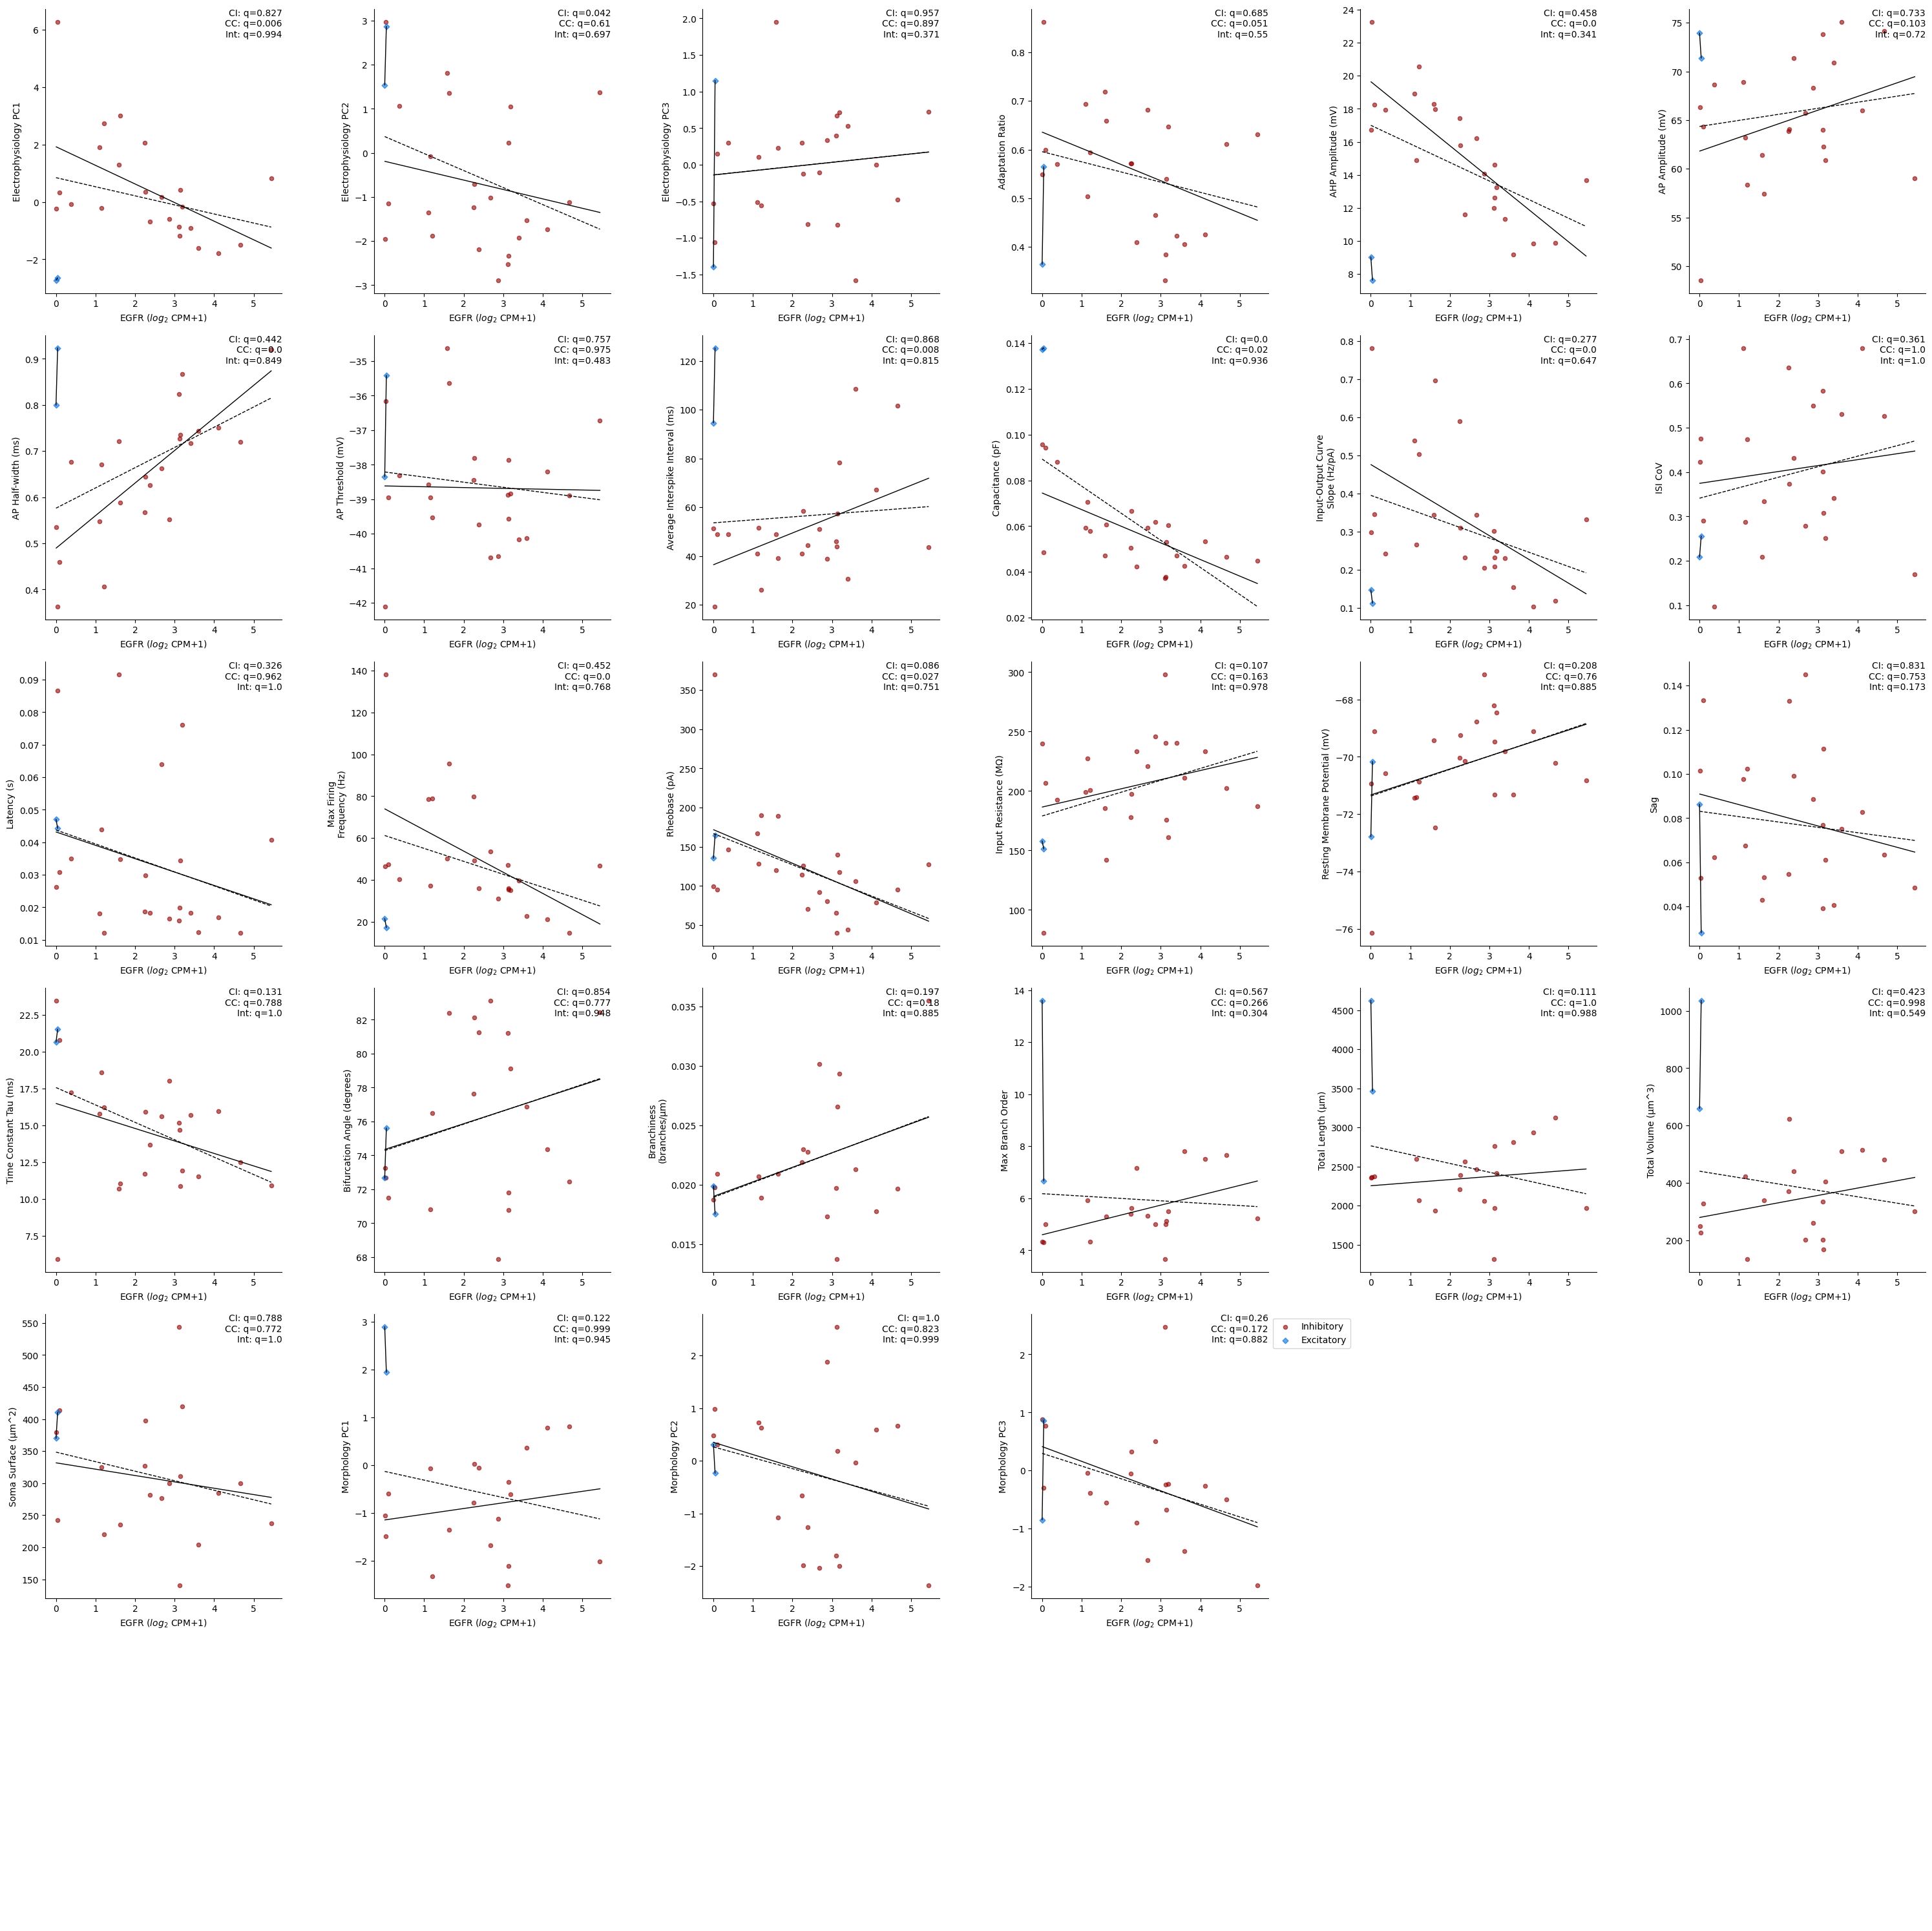

In [ ]:
#Code for printing scatter plots for one gene's correlations
##Problem: Graph's dimensions kind of weird, will probably have to change them 
def print_graph(x):
    gene = x.upper()
    measures = props_ephys + props_morph
    genes = [gene] * len(measures)
    # Set up axes
    xy = int(math.ceil(np.sqrt(len(genes))))
    fig, axes = plt.subplots(xy, xy, figsize = (xy * 5, xy * 5))

    for graph_gene, measure, ax in zip(genes, measures, axes.flat):
        make_scatter(gene, measure, ax)
    make_legend(ax)
    for ax in axes.flat[len(genes):]:
        ax.axis('off')   
    fig.tight_layout()
    plt.show()

#Loop that keeps asking user if they would like to print graphs for their genes until they say No
ask_for_graph = True
while ask_for_graph == True:
    ask_gene = input("Enter a gene for which you would like to create your graphs: ")
    print_graph(ask_gene)
    again = input("Would you like to see other graphs for another gene of your interest? (Y)es of (N)o: ")
    if again.lower() == "n":
        ask_for_graph = False

# Plot Data

Will allow the user to obtain the plot data for a gene of interest as well as the data for each of the electrophysiological/morphological properties that gene was significantly correlated with.

In [ ]:
#Plot Data for a gene of interest and its significant correlations
gene_plot_data = input("Enter a gene for which you would like to see plot data: ")
gene_plot_data = gene_plot_data.upper()
gene_plot_data_id = str(symbol_to_id[gene_plot_data])
df = ephys
line_labels = [{'exc': 1, 'inh': 0}[line.split('__')[-1]] for line in df.columns]
sig_corr = filtered_data[(filtered_data['gene_symbol'] == gene_plot_data)]
prop_and_gene = sig_corr['property'].to_list()  
prop_and_gene.append(gene_plot_data_id)
exc = [n > 0.5 for n in line_labels]
inh = [n <= 0.5 for n in line_labels]
exc_data = pd.DataFrame(df.loc[:, exc].loc[prop_and_gene])
exc_data = exc_data.transpose()
exc_data = exc_data.rename(columns = {gene_plot_data_id : gene_plot_data})
print(exc_data)
inh_data = pd.DataFrame(df.loc[:, inh].loc[prop_and_gene])
inh_data = inh_data.transpose()
inh_data = inh_data.rename(columns = {gene_plot_data_id : gene_plot_data})
print(inh_data)

# Correlation Graphs (Single Relation)

Will allow the user to obtain a correlation graph of a gene and property of their choice. When specifiying the property, the user must use one of the abbreviations listed below in order for the cell to work (run the 'property_table' cell for the abbreviations' table). The code is case sensitive, however, so the abbreviations for the properties must be typed in how they are listed. Genes can be typed in the same way as before. 

In [ ]:
property_table

In [ ]:
# Scatter plot for a single gene and property
def print_plot(x, y):
    gene = x.upper()
    measure = y
    make_scatter(gene, measure)
    make_legend(plt.gca())
    plt.show()
#Loop that keeps asking user if they would like to print graphs for their genes until they say No
ask_for_graph = True
while ask_for_graph == True:
    ask_gene = input("Enter a gene for which you would like to create your graphs: ")
    ask_prop = input("Enter a property for which you would like to see your gene's relation with (use the abbreviations sepcified above): ")
    print_plot(ask_gene, ask_prop)
    again = input("Would you like to see other graphs for another gene of your interest? (Y)es of (N)o: ")
    if again.lower() == "n":
        ask_for_graph = False
        